In [4]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run
from neuralhydrology.nh_run import eval_run
from neuralhydrology.datasetzoo.srsblstm import SrSbLstm

In [17]:
start_run(config_file=Path("D:/surface_sbsurface LSTM/Sr_Sb_LSTM.yml"), gpu=-1)

2024-12-31 15:20:46,698: Logging to C:\Users\Hydro\runs\development_run_3112_152046\output.log initialized.
2024-12-31 15:20:46,700: ### Folder structure created at C:\Users\Hydro\runs\development_run_3112_152046
2024-12-31 15:20:46,701: ### Run configurations for development_run
2024-12-31 15:20:46,702: experiment_name: development_run
2024-12-31 15:20:46,703: run_dir: C:\Users\Hydro\runs\development_run_3112_152046
2024-12-31 15:20:46,705: train_basin_file: D:\surface_sbsurface LSTM\GSA.txt
2024-12-31 15:20:46,706: validation_basin_file: D:\surface_sbsurface LSTM\GSA.txt
2024-12-31 15:20:46,707: test_basin_file: D:\surface_sbsurface LSTM\GSA.txt
2024-12-31 15:20:46,708: train_start_date: 2011-01-01 00:00:00
2024-12-31 15:20:46,709: train_end_date: 2021-09-30 00:00:00
2024-12-31 15:20:46,710: validation_start_date: 2022-01-01 00:00:00
2024-12-31 15:20:46,711: validation_end_date: 2023-01-01 00:00:00
2024-12-31 15:20:46,712: test_start_date: 2011-01-01 00:00:00
2024-12-31 15:20:46,716:

In [18]:
run_dir = Path("runs/development_run_3112_152046")
eval_run(run_dir=run_dir, period="test")

2024-12-31 16:39:52,213: Using the model weights from runs\development_run_3112_152046\model_epoch050.pt
# Evaluation: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]
2024-12-31 16:39:57,305: Stored metrics at runs\development_run_3112_152046\test\model_epoch050\test_metrics.csv
2024-12-31 16:39:57,308: Stored results at runs\development_run_3112_152046\test\model_epoch050\test_results.p


In [19]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['00000005', '00000006'])

Metrics for Basin 00000005 - QObs:
{'NSE': -0.05894116989966136, 'KGE': 0.2764117934572512, 'RMSE': 24.99665227395098, 'MSE': 624.8326249048185}
Metrics for Basin 00000005 - GWD:
{'NSE': -17.036899906320812, 'KGE': 0.31443721047752193, 'RMSE': 1.952287526152974, 'MSE': 3.811426584772499}


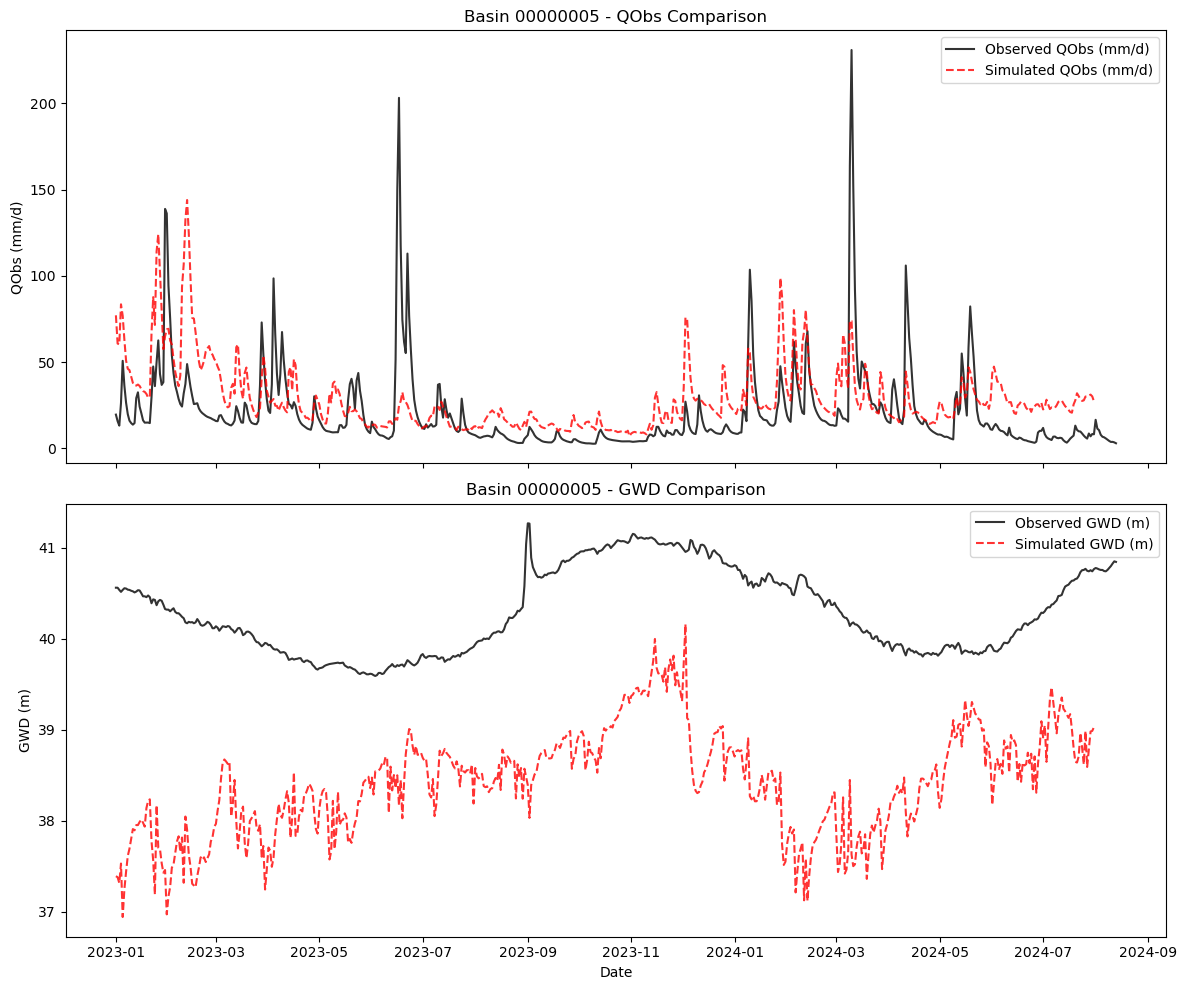

Metrics for Basin 00000006 - QObs:
{'NSE': 0.3315797339906308, 'KGE': 0.4291182823865821, 'RMSE': 19.72311019291447, 'MSE': 389.0010756818466}
Metrics for Basin 00000006 - GWD:
{'NSE': -6.4603644132155535, 'KGE': -0.2674714639160569, 'RMSE': 0.45457431337166426, 'MSE': 0.20663780637732004}


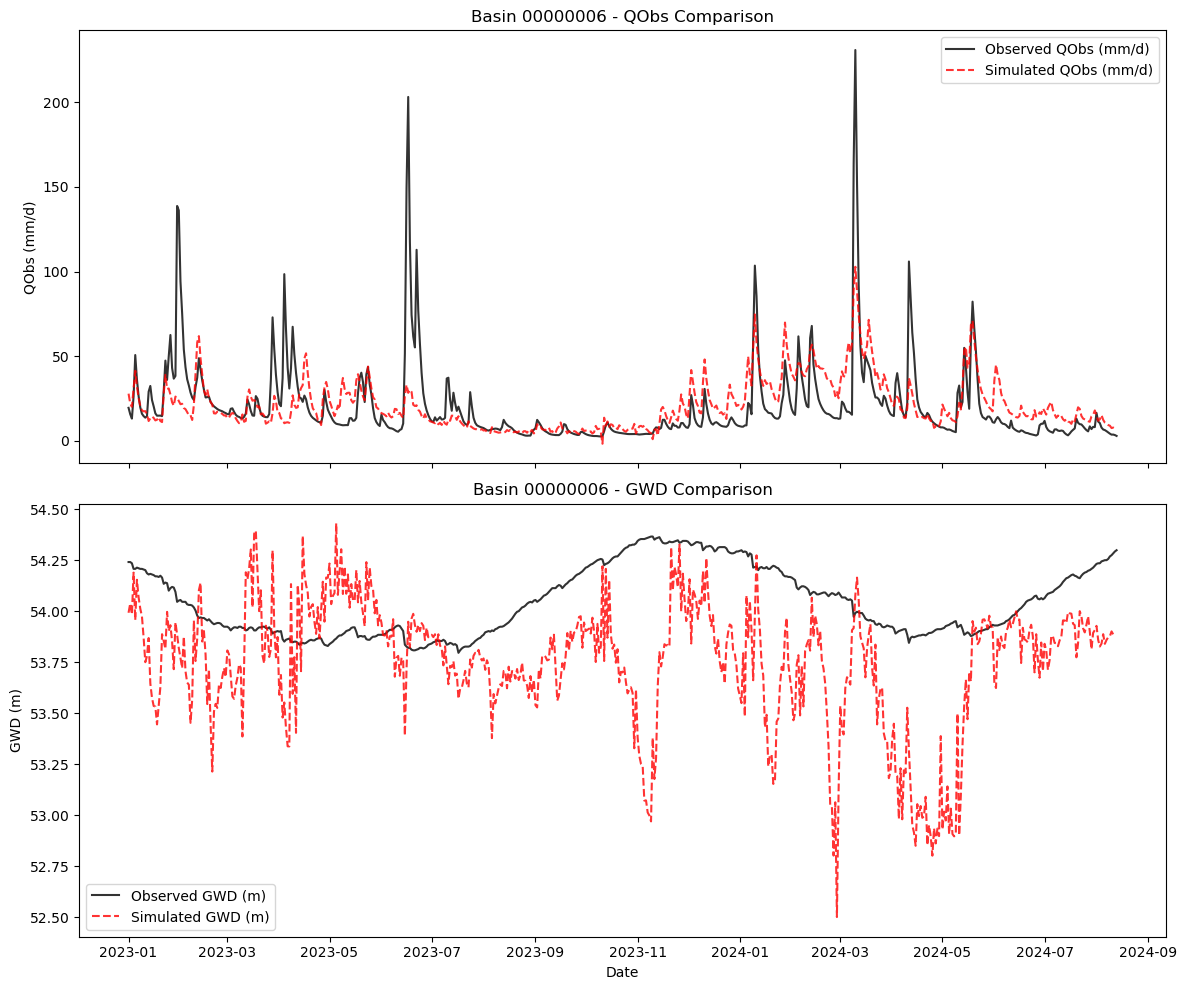

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def load_observations(file_path):
    """
    Load observed QObs and GWD values from a file.

    Parameters:
        file_path (str): Path to the observation file.

    Returns:
        pd.DataFrame: DataFrame with date, QObs, and GWD columns.
    """
    col_names = ['basin', 'Year', 'Mnth', 'Day', 'QObs', 'flag', 'GWD']
    df = pd.read_csv(file_path, sep='\s+', header=None, names=col_names)
    df["date"] = pd.to_datetime(df.Year.map(str) + "/" + df.Mnth.map(str) + "/" + df.Day.map(str), format="%Y/%m/%d")
    df = df.set_index("date")
    return df[["QObs", "GWD"]]

def calculate_metrics(observed, simulated):
    """
    Calculate evaluation metrics: NSE, KGE, RMSE, MSE.

    Parameters:
        observed (array): Observed values.
        simulated (array): Simulated values.

    Returns:
        dict: Dictionary containing NSE, KGE, RMSE, and MSE.
    """
    # Remove NaN values
    mask = ~np.isnan(observed) & ~np.isnan(simulated)
    observed = observed[mask]
    simulated = simulated[mask]

    observed_mean = np.mean(observed)
    sim_mean = np.mean(simulated)
    sim_std = np.std(simulated)
    obs_std = np.std(observed)

    # NSE
    nse = 1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - observed_mean) ** 2))

    # KGE
    correlation = np.corrcoef(observed, simulated)[0, 1]
    kge = 1 - np.sqrt((correlation - 1) ** 2 + ((sim_std / obs_std) - 1) ** 2 + ((sim_mean / observed_mean) - 1) ** 2)

    # RMSE and MSE
    rmse = np.sqrt(mean_squared_error(observed, simulated))
    mse = mean_squared_error(observed, simulated)

    return {"NSE": nse, "KGE": kge, "RMSE": rmse, "MSE": mse}

def plot_simulated_vs_observed(results, basin_ids, obs_files):
    """
    Visualize observed vs simulated data for both QObs and GWD.

    Parameters:
        results (dict): Dictionary containing the basin data.
        basin_ids (list): List of basin IDs to visualize.
        obs_files (dict): Dictionary mapping basin IDs to observation file paths.
    """
    for basin_id in basin_ids:
        # Load observations from file
        obs_data = load_observations(obs_files[basin_id])
        
        # Filter data for dates from 01/01/2023 onwards
        obs_data = obs_data.loc["2023-01-01":]
        
        # Extract simulated data
        data = results[basin_id]['1D']['xr']
        dates = pd.to_datetime(data['date'].values)
        qobs_sim = data['QObs(mm/d)_sim'].values.flatten()
        gwd_sim = data['GWD(m)_sim'].values.flatten()

        # Align observations and simulations by date
        # Use intersection of dates to avoid KeyError
        common_dates = obs_data.index.intersection(dates)
        qobs_obs = obs_data.loc[common_dates, "QObs"].values
        gwd_obs = obs_data.loc[common_dates, "GWD"].values

        qobs_sim = qobs_sim[np.isin(dates, common_dates)]
        gwd_sim = gwd_sim[np.isin(dates, common_dates)]

        # Calculate metrics
        qobs_metrics = calculate_metrics(qobs_obs, qobs_sim)
        gwd_metrics = calculate_metrics(gwd_obs, gwd_sim)

        print(f"Metrics for Basin {basin_id} - QObs:")
        print(qobs_metrics)
        print(f"Metrics for Basin {basin_id} - GWD:")
        print(gwd_metrics)

        # Plotting
        fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

        # Plot QObs
        axes[0].plot(common_dates, qobs_obs, label="Observed QObs (mm/d)", linestyle='-', alpha=0.8, color='black')
        axes[0].plot(common_dates, qobs_sim, label="Simulated QObs (mm/d)", linestyle='--', alpha=0.8, color='red')
        axes[0].set_title(f"Basin {basin_id} - QObs Comparison")
        axes[0].set_ylabel("QObs (mm/d)")
        axes[0].legend()

        # Plot GWD
        axes[1].plot(common_dates, gwd_obs, label="Observed GWD (m)", linestyle='-', alpha=0.8, color='black')
        axes[1].plot(common_dates, gwd_sim, label="Simulated GWD (m)", linestyle='--', alpha=0.8, color='red')
        axes[1].set_title(f"Basin {basin_id} - GWD Comparison")
        axes[1].set_ylabel("GWD (m)")
        axes[1].legend()

        # Common x-axis
        axes[1].set_xlabel("Date")
        plt.tight_layout()
        plt.show()

# Example usage:
basin_ids = ['00000005', '00000006']
obs_files = {
    '00000005': r"C:\Users\Hydro\Data\sr_sb_data\usgs_streamflow\00000005_streamflow_gwd.txt",
    '00000006': r"C:\Users\Hydro\Data\sr_sb_data\usgs_streamflow\00000006_streamflow_gwd.txt"
}
plot_simulated_vs_observed(results, basin_ids, obs_files)


Metrics for Basin 00000005 - QObs:
{'NSE': 0.5372128933752522, 'KGE': 0.5895282980584406, 'RMSE': 20.58746630953006, 'MSE': 423.84376904603533}
Metrics for Basin 00000005 - GWD:
{'NSE': 0.20549525119916767, 'KGE': 0.3659902300635245, 'RMSE': 1.0404329632981282, 'MSE': 1.0825007511173244}


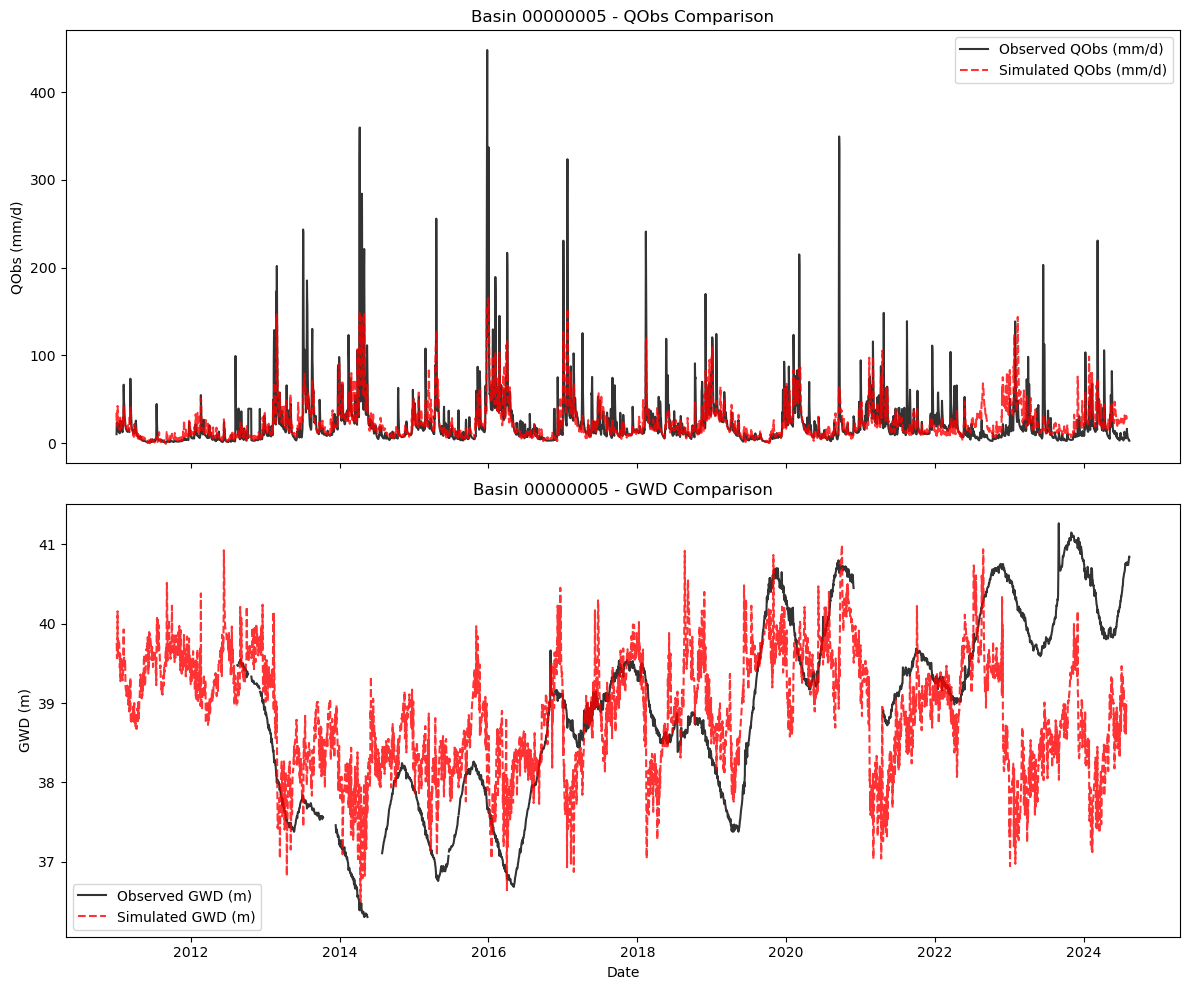

Metrics for Basin 00000006 - QObs:
{'NSE': 0.599190861948873, 'KGE': 0.6266869829815565, 'RMSE': 19.19711551035705, 'MSE': 368.5292439179913}
Metrics for Basin 00000006 - GWD:
{'NSE': -1.9377600879727925, 'KGE': 0.2937530734533087, 'RMSE': 0.4258628883805064, 'MSE': 0.18135919969978767}


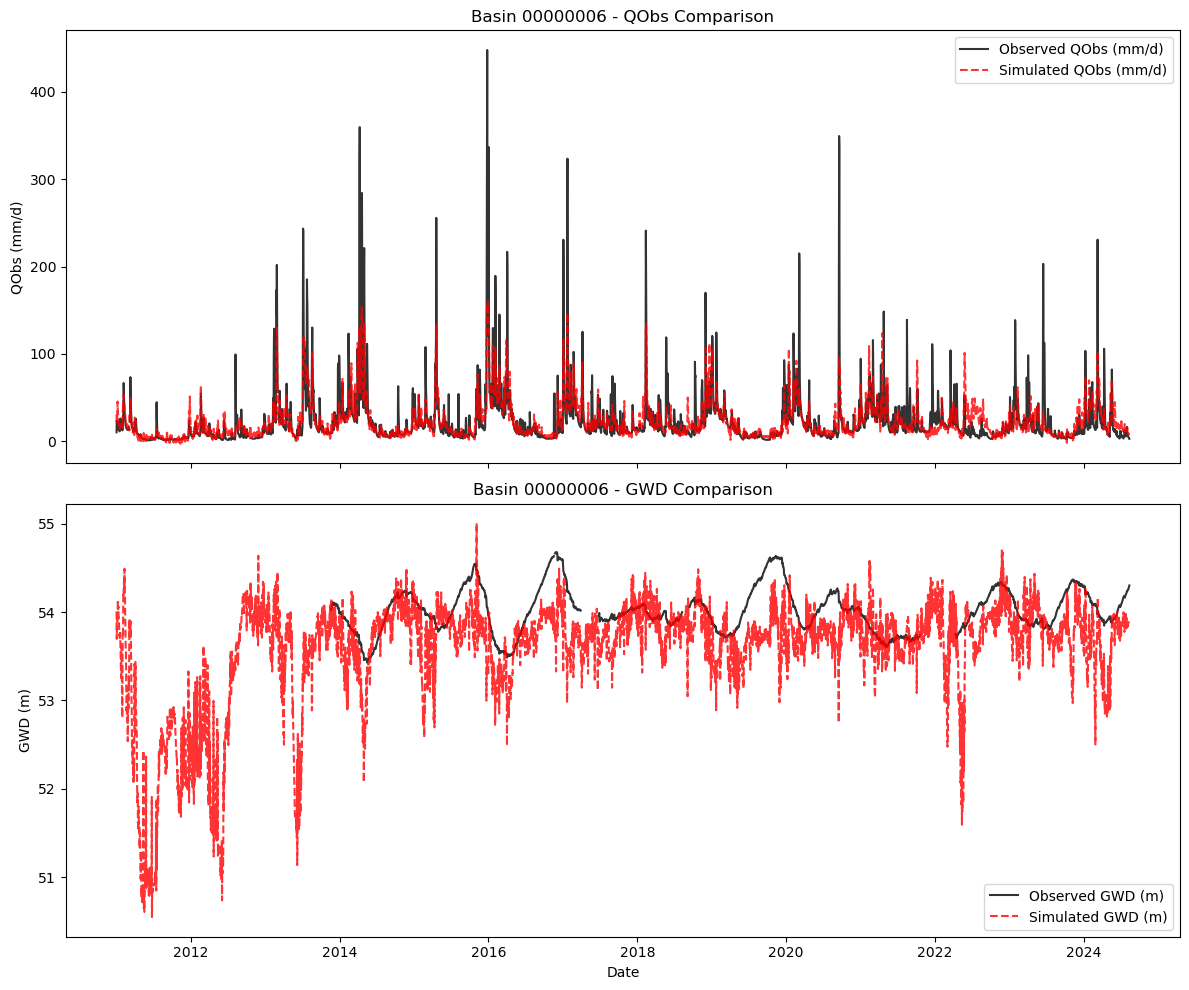

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def load_observations(file_path):
    """
    Load observed QObs and GWD values from a file.

    Parameters:
        file_path (str): Path to the observation file.

    Returns:
        pd.DataFrame: DataFrame with date, QObs, and GWD columns.
    """
    col_names = ['basin', 'Year', 'Mnth', 'Day', 'QObs', 'flag', 'GWD']
    df = pd.read_csv(file_path, sep='\s+', header=None, names=col_names)
    df["date"] = pd.to_datetime(df.Year.map(str) + "/" + df.Mnth.map(str) + "/" + df.Day.map(str), format="%Y/%m/%d")
    df = df.set_index("date")
    return df[["QObs", "GWD"]]

def calculate_metrics(observed, simulated):
    """
    Calculate evaluation metrics: NSE, KGE, RMSE, MSE.

    Parameters:
        observed (array): Observed values.
        simulated (array): Simulated values.

    Returns:
        dict: Dictionary containing NSE, KGE, RMSE, and MSE.
    """
    # Remove NaN values
    mask = ~np.isnan(observed) & ~np.isnan(simulated)
    observed = observed[mask]
    simulated = simulated[mask]

    observed_mean = np.mean(observed)
    sim_mean = np.mean(simulated)
    sim_std = np.std(simulated)
    obs_std = np.std(observed)

    # NSE
    nse = 1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - observed_mean) ** 2))

    # KGE
    correlation = np.corrcoef(observed, simulated)[0, 1]
    kge = 1 - np.sqrt((correlation - 1) ** 2 + ((sim_std / obs_std) - 1) ** 2 + ((sim_mean / observed_mean) - 1) ** 2)

    # RMSE and MSE
    rmse = np.sqrt(mean_squared_error(observed, simulated))
    mse = mean_squared_error(observed, simulated)

    return {"NSE": nse, "KGE": kge, "RMSE": rmse, "MSE": mse}

def plot_simulated_vs_observed(results, basin_ids, obs_files):
    """
    Visualize observed vs simulated data for both QObs and GWD.

    Parameters:
        results (dict): Dictionary containing the basin data.
        basin_ids (list): List of basin IDs to visualize.
        obs_files (dict): Dictionary mapping basin IDs to observation file paths.
    """
    for basin_id in basin_ids:
        # Load observations from file
        obs_data = load_observations(obs_files[basin_id])
        
        # Extract simulated data
        data = results[basin_id]['1D']['xr']
        dates = pd.to_datetime(data['date'].values)
        qobs_sim = data['QObs(mm/d)_sim'].values.flatten()
        gwd_sim = data['GWD(m)_sim'].values.flatten()

        # Align observations and simulations by date
        # Use intersection of dates to avoid KeyError
        common_dates = obs_data.index.intersection(dates)
        qobs_obs = obs_data.loc[common_dates, "QObs"].values
        gwd_obs = obs_data.loc[common_dates, "GWD"].values

        qobs_sim = qobs_sim[np.isin(dates, common_dates)]
        gwd_sim = gwd_sim[np.isin(dates, common_dates)]

        # Calculate metrics
        qobs_metrics = calculate_metrics(qobs_obs, qobs_sim)
        gwd_metrics = calculate_metrics(gwd_obs, gwd_sim)

        print(f"Metrics for Basin {basin_id} - QObs:")
        print(qobs_metrics)
        print(f"Metrics for Basin {basin_id} - GWD:")
        print(gwd_metrics)

        # Plotting
        fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

        # Plot QObs
        axes[0].plot(common_dates, qobs_obs, label="Observed QObs (mm/d)", linestyle='-', alpha=0.8, color='black')
        axes[0].plot(common_dates, qobs_sim, label="Simulated QObs (mm/d)", linestyle='--', alpha=0.8, color='red')
        axes[0].set_title(f"Basin {basin_id} - QObs Comparison")
        axes[0].set_ylabel("QObs (mm/d)")
        axes[0].legend()

        # Plot GWD
        axes[1].plot(common_dates, gwd_obs, label="Observed GWD (m)", linestyle='-', alpha=0.8, color='black')
        axes[1].plot(common_dates, gwd_sim, label="Simulated GWD (m)", linestyle='--', alpha=0.8, color='red')
        axes[1].set_title(f"Basin {basin_id} - GWD Comparison")
        axes[1].set_ylabel("GWD (m)")
        axes[1].legend()

        # Common x-axis
        axes[1].set_xlabel("Date")
        plt.tight_layout()
        plt.show()

# Example usage:
basin_ids = ['00000005', '00000006']
obs_files = {
    '00000005': r"C:\Users\Hydro\Data\sr_sb_data\usgs_streamflow\00000005_streamflow_gwd.txt",
    '00000006': r"C:\Users\Hydro\Data\sr_sb_data\usgs_streamflow\00000006_streamflow_gwd.txt"
}
plot_simulated_vs_observed(results, basin_ids, obs_files)
